# Deep Learning for Chemistry

This notebook is based on the excellent [Kaggle tutorial](https://www.kaggle.com/vladislavkisin/tutorial-ml-in-chemistry-research-rdkit-mol2vec) from [Vlad Kisin](https://www.kaggle.com/vladislavkisin). In this example, you'll learn how to read a Chemistry datafile and create predictive models of [lipophilicity](https://en.wikipedia.org/wiki/Partition_coefficient#Partition_coefficient_and_log_P). 

Lipophilicity is the ability of a chemical compound to dissolve in non-polar (fatty or oily) solvents. In simple terms, if you had a glass of oil and water (which will separate with one on top of the other as in the figure below), then lipophilicity is the proportion of how much a chemical dissovles in the water portion versus the oil portion. In the figure below there are 3 molecules in water to every 1 molecule in oil. P is 3 and the log P is $\log_{10}{3} = 0.477$.

Lipophilicity contributes to the absorption, distribution, metabolism, excretion, and toxicity of a pharmaceutical and contributes to a drug's potency and selectivity.

![Figure1](logP.png)

I'll demonstrate how to load the raw data from a CSV file and use the [RD-Kit](https://github.com/rdkit/rdkit) and [Mol2Vec](https://pubs.acs.org/doi/10.1021/acs.jcim.7b00616) packages to create features based on the chemical formula of a molecule.

## Import the usual libraries

You might need to install [Seaborn](https://seaborn.pydata.org/) via `pip install seaborn` or `conda install seaborn` and [Pandas](https://pandas.pydata.org/) via `pip install pandas` or `conda install pandas`

Here are the commands I used to create the conda environment:

```
conda create -n chem python=3.8 pip jupyter matplotlib seaborn
conda activate chem
conda install -c conda-forge rdkit
pip install git+https://github.com/samoturk/mol2vec
wget https://raw.githubusercontent.com/tonyreina/mol2vec/master/mol2vec/features.py -O  ~/anaconda3/envs/chem/lib/python3.8/site-packages/mol2vec/features.py
wget https://github.com/samoturk/mol2vec_notebooks/blob/master/Notebooks/model_300dim.pkl
pip install -U tensorflow==2.4.1
pip install openvino-tensorflow==0.5.0
conda install scikit-learn
```

## Important!
Currently (MAY 2021) the [OpenVINO™-TensorFlow bridge](https://github.com/openvinotoolkit/openvino_tensorflow) only works with Python 3.8 and TensorFlow 2.4.1. You may want to check the [website](https://github.com/openvinotoolkit/openvino_tensorflow) to see what version of TensorFlow and Python you need to use. 

You only need the OpenVINO™-TensorFlow bridge and the specific version of TensorFlow if you want to complete the last section of this tutorial. Otherwise, any current version of TensorFlow should work.

In [1]:
%matplotlib inline

import numpy as np                #!pip install numpy
import pandas as pd               #!pip install pandas
import matplotlib.pyplot as plt   #!pip install matplotlib
import seaborn as sns             #!pip install seaborn

## Load the raw data from the CSV file for the lipophilicity dataset

The lipophilicity dataset is available on [Kaggle](https://www.kaggle.com/matthewmasters/chemical-structure-and-logp) and released under the Public Domain ([CC0](https://creativecommons.org/share-your-work/public-domain/cc0/)). The raw data is in a CSV file with the SMILES notation of the chemical in the first column and the lipophilicity (logP) in the second column.

[SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) stands for the **S**implified **M**olecular **I**nput **L**ine **E**ntry **S**ystem which is a method for describing the structure of chemical species using short ASCII strings. Essentially it's a short-hand notation for describing a molecule including information about which atoms are connected together, the types of chemical bonds, and the 2D structure. In SMILES notation, 'C' represents a carbon atom, 'N' represents a nitrogen atom, 'Cl' represents a Chlorine atom, and '=' indicates a double bond between the adjacent atoms. For example, in the figure below the SMILES notation for the top/left molecule is **Cl
ClC\[C@H\](\[C@@H\](C)Cl)Cl**.

A good resource for learning about SMILES notation is:

Quirós, M., Gražulis, S., Girdzijauskaitė, S. et al. Using SMILES strings for the description of chemical connectivity in the Crystallography Open Database. J Cheminform 10, 23 (2018). https://doi.org/10.1186/s13321-018-0279-6

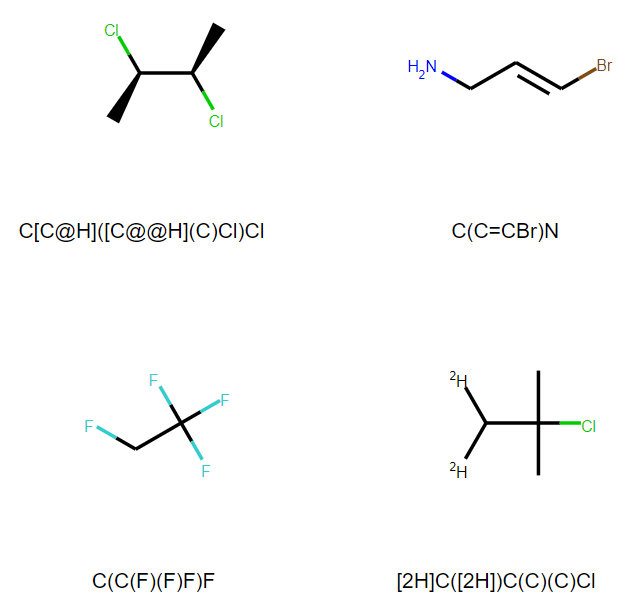

In [2]:
df = pd.read_csv('logP_dataset.csv', names=['smiles', 'logP']) #load the CSV file
df.head()  # Display a few rows

,smiles,logP
0,C[C@H]([C@@H](C)Cl)Cl,2.3
1,C(C=CBr)N,0.3
2,CCC(CO)Br,1.3
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0
4,CCCOCCP,0.6


## What is our goal?

We'd like to create an algorithm **f(x)** that takes the **smiles** data as input and returns the **logP** as the output. For example,

```
f( 'C[C@H]([C@@H](C)Cl)Cl' ) = 2.3
f( 'CCCOCCP' )               = 0.6
```

We can accomplish this with machine learning.

## RD-Kit
[RD-Kit](https://github.com/rdkit/rdkit) is an open-source (BSD-3) Python package for data scientists to work with Chemistry data. It has some excellent modules that allow us to preprocess data from chemistry experiments.

You can install it using the conda package:
`conda install -c rdkit rdkit`

With RD-Kit we can transform the SMILES notation into a more useful Python object called a *Mol* (for molecule). Mol objects contain the atoms, bonds, connectivity and coordinates of a molecule. It adds important 3D information, such as the distance between atoms, that may be useful to our model. We can use *Mol* objects to craft features of the chemical to provide as inputs to our model.

In [3]:
#Importing Chem module
from rdkit import Chem 

#Method transforms smiles strings to mol rdkit object
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

df.head()

RDKit WARNING: [19:17:57] Enabling RDKit 2019.09.3 jupyter extensions


,smiles,logP,mol
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7fe2c0e0bd00>
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7fe2b85033a0>
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7fe2b8503be0>
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,<rdkit.Chem.rdchem.Mol object at 0x7fe2b8503b20>
4,CCCOCCP,0.6,<rdkit.Chem.rdchem.Mol object at 0x7fe2b8503c40>


## Plot some chemical structures

Once we have our molecules as *Mol* Python objects, then RD-Kit allows us to plot the chemical structures easily.

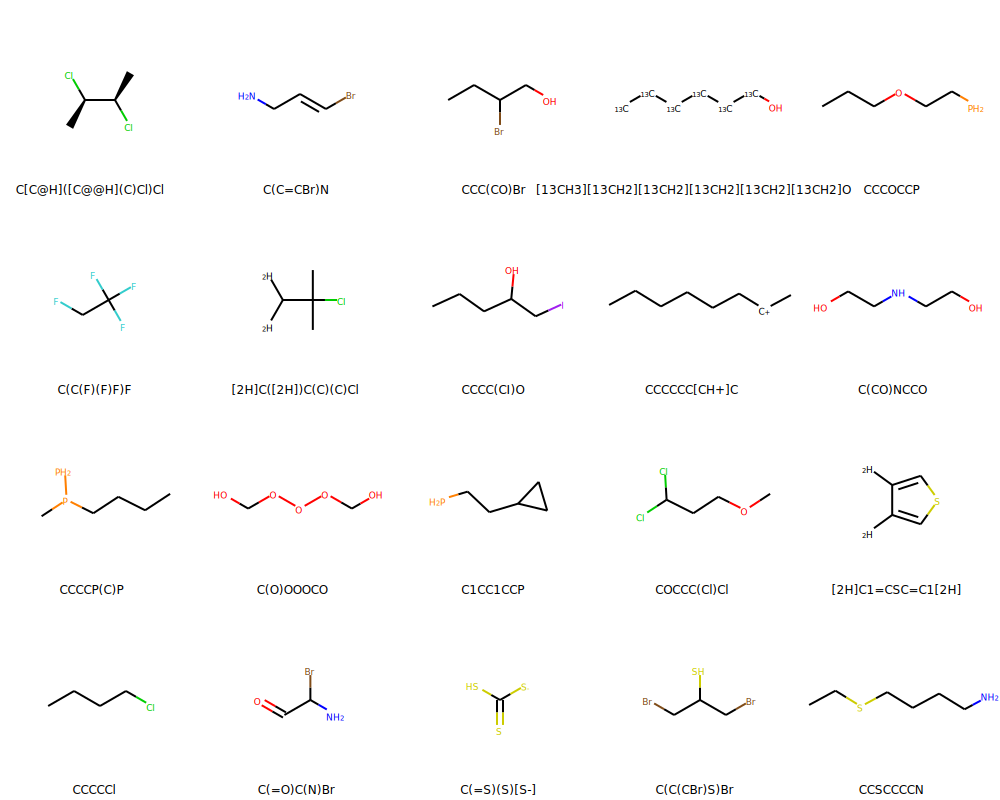

In [4]:
from rdkit.Chem import Draw

number_to_print = 20
mols = df['mol'][:number_to_print]

#MolsToGridImage allows to show several molecules in a grid
Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=True, legends=list(df['smiles'][:number_to_print].values))

## Use RD-Kit to create features for the model

Now that we have the molecule in *Mol* format, we can use RD-Kit's built in functions to create new features for our model. For example, we can add columns for the number of total atoms in the molecule and the number **Chloride (Cl)** atoms in the molecule. These features might be important in predicting **logP**. 

Note: The first function we use is `Chem.AddHs`. Typically, the SMILES format does not explicitly show the **Hydrogen atoms (H)**. They are implied. It actually helps us a bit in our model accuracy to specifically add these back. (Try commenting out the next line to see its effect on model performance.) 

In [5]:
# AddHs function adds H atoms to a MOL (as Hs in SMILES are usualy ignored)
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))

## Additional features

Let's add some other features such as the number of atoms in the molecule and the number of "heavy" atoms in the molecule. These might be important in determining the logP value. Look through the [RD-Kit documentation](https://www.rdkit.org/docs/source/rdkit.Chem.Lipinski.html) to add more features if you'd like to get a better model. 

In [6]:
# GetNumAtoms() method returns a general nubmer of all atoms in a molecule
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())

# GetNumHeavyAtoms() method returns a nubmer of all atoms in a molecule with molecular weight > 1
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

In [7]:
#We're going to searches patterns and use it for a list of most common atoms only
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C', 'O', 'N', 'Cl', 'P', 'Br', 'F'], df)

In [8]:
from rdkit.Chem import Descriptors
df['tpsa'] = df['mol'].apply(lambda x: Descriptors.TPSA(x)) #https://en.wikipedia.org/wiki/Polar_surface_area
df['mol_w'] = df['mol'].apply(lambda x: Descriptors.ExactMolWt(x)) # https://en.wikipedia.org/wiki/Molecular_mass
df['num_valence_electrons'] = df['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x)) # https://en.wikipedia.org/wiki/Valence_electron
df['num_heteroatoms'] = df['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

In [9]:
df.head()

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_Br_atoms,num_of_F_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7fe2bbb57c40>,14,6,4,0,0,2,0,0,0,0.00,126.000306,38,2
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7fe2b7f36700>,11,5,3,0,1,0,0,1,0,26.02,134.968361,30,2
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7fe2b7f36760>,15,6,4,1,0,0,0,1,0,20.23,151.983677,38,2
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,<rdkit.Chem.rdchem.Mol object at 0x7fe2b7f36820>,21,7,6,1,0,0,0,0,0,20.23,108.124594,44,1
4,CCCOCCP,0.6,<rdkit.Chem.rdchem.Mol object at 0x7fe2b7f367c0>,20,7,5,1,0,0,1,0,0,9.23,120.070402,44,2


## Use the GenSim word2vec model

[GenSim](https://radimrehurek.com/gensim/index.html#) is a natural language processing ([NLP](https://en.wikipedia.org/wiki/Natural_language_processing)) Python library for creating topic modeling and word embedding ([word vectors](https://en.wikipedia.org/wiki/Word2vec)). A word vector contains a list of floating point numbers that uniquely identify the word (see figure below). Remember that computers only really understand numbers (not language) so we need to convert the SMILES notation to a vector of numbers in order to use it in machine learning. If we do it correctly, then vectors that are "close" together in this word space are typically similar in meaning. More information on word embeddings can be found [here](https://en.wikipedia.org/wiki/Word_embedding).

For our model, we'll consider each molecule to be a "word" in the language of chemistry. So **C\[C@H\](\[C@@H\](C)Cl)Cl** could replace **Houses** in the figure below and **C(C=CBr)N** could replace **puppy**. We can then create a word vector embedding for our molecule (the numbers in **d1-d7**). In this case, we'll use vectors of length 300 and vectors that are close together represent molecules which should have similar chemical properties (including logP if we are lucky).

<br>
<br>

![word embeddings](https://journals.plos.org/plosone/article/figure/image?size=large&download=&id=10.1371/journal.pone.0231189.g008)

Figure citation: Rozado D (2020) Wide range screening of algorithmic bias in word embedding models using large sentiment lexicons reveals underreported bias types. PLoS ONE 15(4): e0231189. https://doi.org/10.1371/journal.pone.0231189, Creative commons license

## mol2vec

[Mol2Vec](https://pubs.acs.org/doi/10.1021/acs.jcim.7b00616) is an unsupervised machine learning approach to learn vector representations (word embeddings) of molecular substructures. We've already converted the SMILES notation of the chemical into a Mol Python object. Mol2Vec converts that object into a word2vec vector (a sentence) that we will use as an additional feature of the model.

## Installing GenSim and Mol2Vec 

`pip install git+https://github.com/samoturk/mol2vec` which will get [GenSim](https://radimrehurek.com/gensim/index.html) and [mol2vec](https://github.com/samoturk/mol2vec).

Note: mol2vec currently has an error with GenSim 4. 

>AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

I have created a [patch](https://github.com/samoturk/mol2vec/pull/16) here which you can just use to overwrite the file on your system. (Hopefully, the PR will be merged and this step won't be needed.) On my system, the `features.py` file is `~/anaconda3/envs/chem/lib/python3.8/site-packages/mol2vec/features.py` so I did.

`wget https://raw.githubusercontent.com/tonyreina/mol2vec/master/mol2vec/features.py -O ~/anaconda3/envs/chem/lib/python3.8/site-packages/mol2vec/features.py`

You may need to restart the Jupyter Notebook server for the change to take effect.

You should also download the pre-trained [model_300dim.pkl](https://github.com/samoturk/mol2vec_notebooks/blob/master/Notebooks/model_300dim.pkl)

In [10]:
import requests

url = 'https://github.com/samoturk/mol2vec_notebooks/raw/master/Notebooks/model_300dim.pkl'
file_to_download = requests.get(url, allow_redirects=True)

open('model_300dim.pkl', 'wb').write(file_to_download.content)

26567327

In [11]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

/home/reina/anaconda3/envs/chem/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [12]:
#Loading pre-trained model via word2vec
from gensim.models import word2vec  # https://radimrehurek.com/gensim/index.html#install
w2vec_model = word2vec.Word2Vec.load('model_300dim.pkl') # Download from https://github.com/samoturk/mol2vec_notebooks/blob/master/Notebooks/model_300dim.pkl

In [13]:
train_df = df.drop(columns=['smiles', 'mol', 'logP'])

## Mol2Vec Sentences

In [14]:
#Constructing sentences
train_df['sentence'] = df.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
train_df['mol2vec'] = [DfVec(x) for x in sentences2vec(train_df['sentence'], w2vec_model, unseen='UNK')]

y = df['logP'].values
X = np.array([x.vec for x in train_df['mol2vec']])

## Combine features

Here we'll combine the Mol2Vec Sentences (a chemical word2vec vector) with the RD-Kit calculated features (such as, number of Oxygen atoms in the molecule). We'll use these to predict the logP value.

In [15]:
X = pd.concat((pd.DataFrame(X), train_df.drop(["mol2vec", "sentence"], axis=1)), axis=1)

## Train/Validation/Test Splits

Finally, we split the data into random training, validation, and testing splits as we would for any machine learning project.

`!pip install scikit-learn`

In [16]:
from sklearn.linear_model import RidgeCV   #!pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train, X_remain, y_train, y_remain = train_test_split(X, y, test_size=.2, random_state=816)
X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size=.5, random_state=817)

## Ridge regression

Let's first try a [ridge regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html?highlight=regression#sklearn.linear_model.ridge_regression) model using Scikit Learn to predict the [logP](https://en.wikipedia.org/wiki/Partition_coefficient_) from the [Mol2Vec](https://github.com/samoturk/mol2vec).

Feel free to try other classical machine learning regression models if you'd like.

In [17]:
ridge_model = RidgeCV()
ridge_model.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

## Plot the performance of the model

We'll plot the accuracy of the model predictions using the function below.

In [18]:
def plot_evaluation(model, X_test, y_test, title="Test"):
    """
    Scatter plot between target and prediction logP values
    """
    
    prediction = np.squeeze(model.predict(X_test))
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)

    plt.figure(figsize=(10,10))
    sns.regplot(x=prediction, y=y_test, scatter_kws={"color": "blue"}, line_kws={"color": "red"});
    plt.xlabel('Model Prediction', fontsize=24);
    plt.ylabel('Measured logP', fontsize=24);
    plt.xticks(fontsize=24);
    plt.yticks(fontsize=24);
    plt.suptitle('Predicting logP from SMILES', fontsize=32);
    plt.title(f'{title}: MAE = {mae:.3f}, MSE = {mse:.3f}', fontsize=24);
    plt.grid(True);
         
    cc = np.corrcoef(y_test, prediction)
    plt.text(-1.5, 2, f"Correlation\ncoefficient\n{cc[0][1]:.4f}", fontsize=24, 
             horizontalalignment="center", backgroundcolor="black", color="white")
#     print('MAE score:', round(mae, 4))
#     print('MSE score:', round(mse,4))

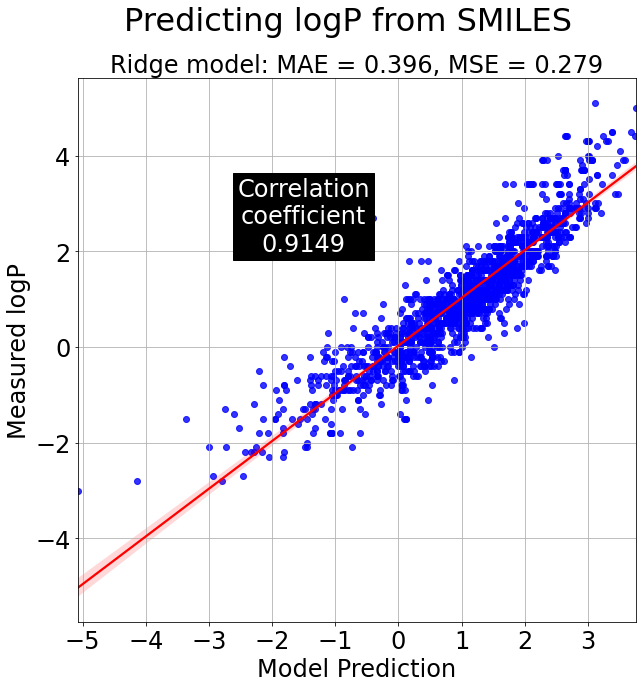

In [19]:
plot_evaluation(ridge_model, X_test, y_test, "Ridge model")

## Plot some example predictions

Let's plot the molecular structure and measured/predicted logP values.

In [48]:
def plot_example(model, X_test, y_test, df, idx=0):
    """
    Plot the chemical, the measured logP, and the predicted logP
    """

    prediction = np.squeeze(model.predict(np.expand_dims(X_test.iloc[idx], 0))[0])
    
    target = df[df.index==X_test.index[idx]]["logP"].values[0]
    
    display(df[df.index==X_test.index[idx]]["mol"].values[0])
    smiles = df[df.index==X_test.index[idx]]["smiles"].values[0]
    print(f"SMILES notation: {smiles}")
    print(f"Target logP = {target:.3f}, Prediction logP = {prediction:.3f}")
    print("="*50)
    

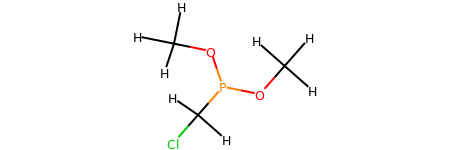

SMILES notation: COP(CCl)OC
Target logP = 0.700, Prediction logP = 0.974


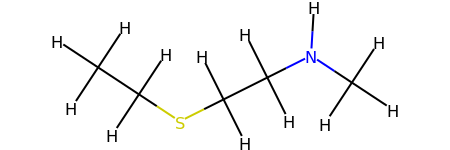

SMILES notation: CCSCCNC
Target logP = 0.800, Prediction logP = 1.436


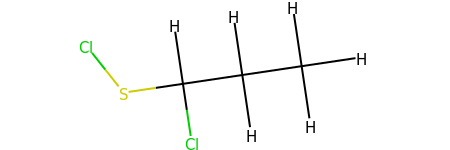

SMILES notation: CCC(SCl)Cl
Target logP = 2.900, Prediction logP = 2.710


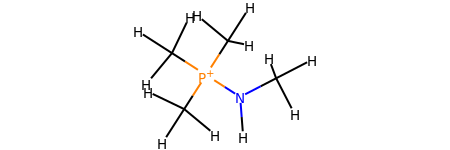

SMILES notation: CN[P+](C)(C)C
Target logP = -0.300, Prediction logP = 0.399


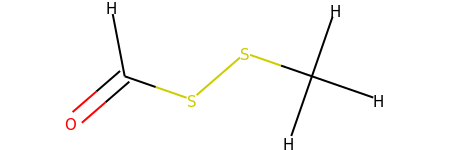

SMILES notation: CSSC=O
Target logP = 0.700, Prediction logP = 0.643


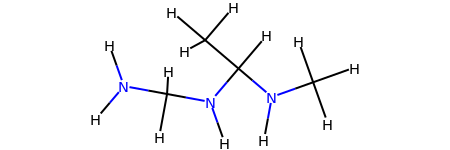

SMILES notation: CC(NC)NCN
Target logP = -0.900, Prediction logP = -0.803


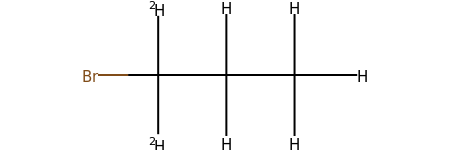

SMILES notation: [2H]C([2H])(CC)Br
Target logP = 2.100, Prediction logP = 1.765


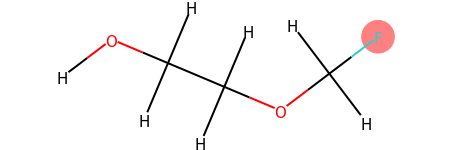

SMILES notation: C(COCF)O
Target logP = -0.200, Prediction logP = -0.007


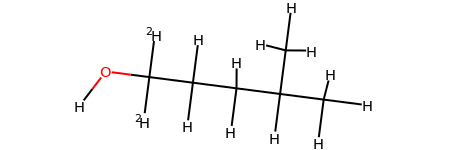

SMILES notation: [2H]C([2H])(CCC(C)C)O
Target logP = 1.600, Prediction logP = 1.527


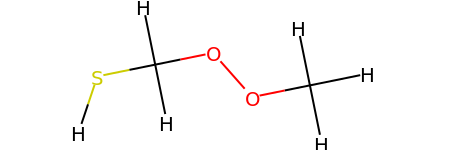

SMILES notation: COOCS
Target logP = 0.500, Prediction logP = 0.820


In [49]:
indicies = np.random.choice(range(len(X_test)), 10) # Try a few examples

for idx in indicies:
    plot_example(ridge_model, X_test, y_test, df, idx)

## TensorFlow Model

Let's create a simple multi-layer neural network using TensorFlow. We can compare our TensorFlow neural network with the Ridge Regression model.

In [22]:
import tensorflow as tf

## A very simple multi-layered perceptron with dropout

This is about as simple a neural network topology as you can get.

In [23]:
inputs = tf.keras.layers.Input(shape=(X_train.shape[1]), name="mol2vec")

dense1 = tf.keras.layers.Dense(128, activation="relu")(inputs)
drop1  = tf.keras.layers.Dropout(0.3)(dense1)
prediction = tf.keras.layers.Dense(1, activation="linear", name="logP_value")(drop1)

In [24]:
tf_model = tf.keras.models.Model(inputs=[inputs], outputs=[prediction], name="logP_Model")

## Print TensorFlow model

In [26]:
tf_model.summary()

Model: "logP_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mol2vec (InputLayer)         [(None, 113)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               14592     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
logP_value (Dense)           (None, 1)                 129       
Total params: 14,721
Trainable params: 14,721
Non-trainable params: 0
_________________________________________________________________


## Loss and metrics

We'll use the mean average error ([MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) or L1-norm) and mean squared error ([MSE](https://en.wikipedia.org/wiki/Mean_squared_error) or L2-norm) for the loss and goodness of fit.

In [25]:
tf_model.compile(loss="mse",
              metrics=["mse", "mae"],
              optimizer=tf.keras.optimizers.Adam(lr=3e-4)) # Learning rate must be low

## Add callbacks

We'll add early stopping, TensorBoard, and model checkpoints.

You can view the TensorBoard by running:

`tensorboard --logdir logP_model`

In [27]:
%load_ext tensorboard

stopping = tf.keras.callbacks.EarlyStopping(patience=30, verbose=1, restore_best_weights=True)

tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs')

checkpoint_dir = "logP_model"
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir, monitor='val_loss', verbose=1, save_best_only=True)

In [28]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 29385), started 0:10:05 ago. (Use '!kill 29385' to kill it.)

## Train the TensorFlow model

In [ ]:
tf_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, callbacks=[stopping, tensorboard, checkpoint])

## Test the accuracy of the final TensorFlow model on the holdout test set

In [30]:
loss, mse, mae = tf_model.evaluate(X_test, y_test)
prediction = tf_model.predict(X_test)

46/46 [==============================] - 0s 639us/step - loss: 0.1281 - mse: 0.1281 - mae: 0.2693


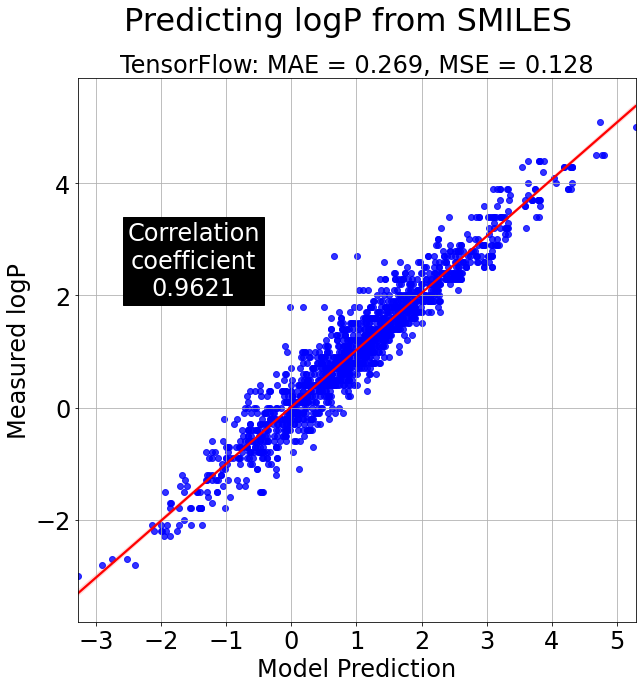

In [31]:
plot_evaluation(tf_model, X_test, y_test, "TensorFlow")

## Plot some example predictions

Let's plot the molecular structure and meaasured/predicted logP values. We'll use the same indicies as we did for the Ridge 
Regression.

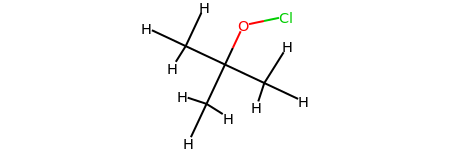

Target logP = 1.800, Prediction logP = 1.664


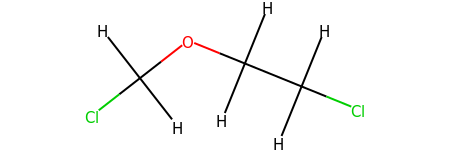

Target logP = 1.400, Prediction logP = 1.364


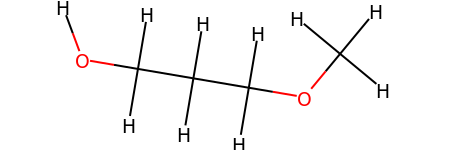

Target logP = -0.200, Prediction logP = -0.083


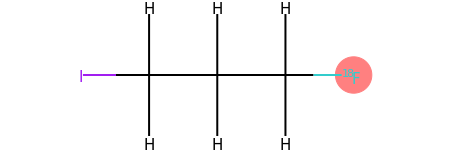

Target logP = 2.000, Prediction logP = 2.197


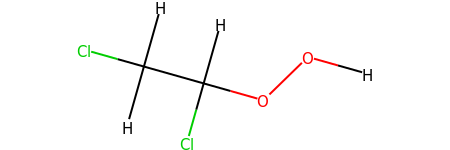

Target logP = 0.900, Prediction logP = 0.890


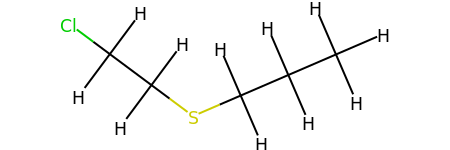

Target logP = 2.400, Prediction logP = 2.433


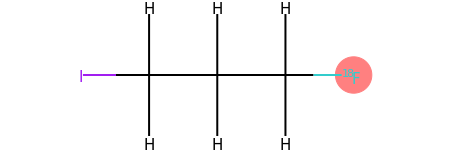

Target logP = 2.000, Prediction logP = 2.197


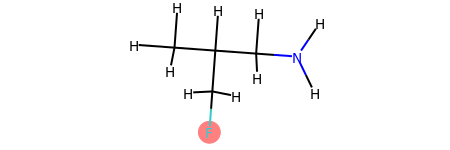

Target logP = 0.400, Prediction logP = 0.455


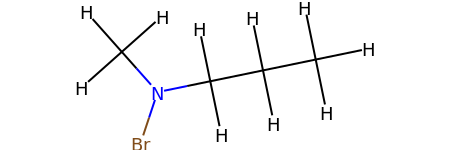

Target logP = 1.700, Prediction logP = 1.477


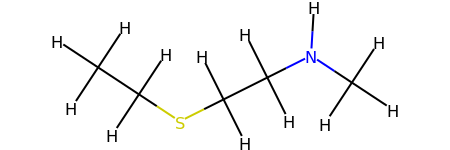

Target logP = 0.800, Prediction logP = 1.127


In [40]:
for idx in indicies:
    plot_example(tf_model, X_test, y_test, df, idx)

## Let's finally compare the TensorFlow model to the Ridge Regression model

In [33]:
def plot_both_evaluation(tf_model, ridge_model, X_test, y_test):
    """
    Scatter plot between target and prediction logP values for both models
    """
    
    prediction_tf = tf_model.predict(X_test)
    mae_tf = mean_absolute_error(y_test, prediction_tf)
    mse_tf = mean_squared_error(y_test, prediction_tf)
    
    prediction_ridge = ridge_model.predict(X_test)
    mae_ridge = mean_absolute_error(y_test, prediction_ridge)
    mse_ridge = mean_squared_error(y_test, prediction_ridge)

    plt.figure(figsize=(20,10))
    plt.subplot(1,2,2);
    sns.regplot(x=prediction_tf, y=y_test, scatter_kws={"color": "blue"}, line_kws={"color": "red"});
    plt.xlabel('Model Prediction', fontsize=24);
    plt.ylabel('Measured logP', fontsize=24);
    plt.xticks(fontsize=24);
    plt.yticks(fontsize=24);
    plt.suptitle('Predicting logP from SMILES', fontsize=32);
    plt.title(f'TensorFlow: MAE = {mae_tf:.3f}, MSE = {mse_tf:.3f}', fontsize=24);
    plt.grid(True);
    cc = np.corrcoef(y_test, np.squeeze(prediction_tf))
    plt.text(-1.5, 2, f"Correlation\ncoefficient\n{cc[0][1]:.4f}", fontsize=24, 
             horizontalalignment="center", backgroundcolor="black", color="white")
    
    plt.subplot(1,2,1);
    sns.regplot(x=prediction_ridge, y=y_test, scatter_kws={"color": "blue"}, line_kws={"color": "red"});
    plt.xlabel('Model Prediction', fontsize=24);
    plt.ylabel('Measured logP', fontsize=24);
    plt.xticks(fontsize=24);
    plt.yticks(fontsize=24);
    plt.suptitle('Predicting logP from SMILES', fontsize=32);
    plt.title(f'Ridge MAE = {mae_ridge:.3f}, MSE = {mse_ridge:.3f}', fontsize=24);
    
    cc = np.corrcoef(y_test, np.squeeze(prediction_ridge))
    plt.text(-1.5, 2, f"Correlation\ncoefficient\n{cc[0][1]:.4f}", fontsize=24, 
             horizontalalignment="center", backgroundcolor="black", color="white")
    plt.grid(True);

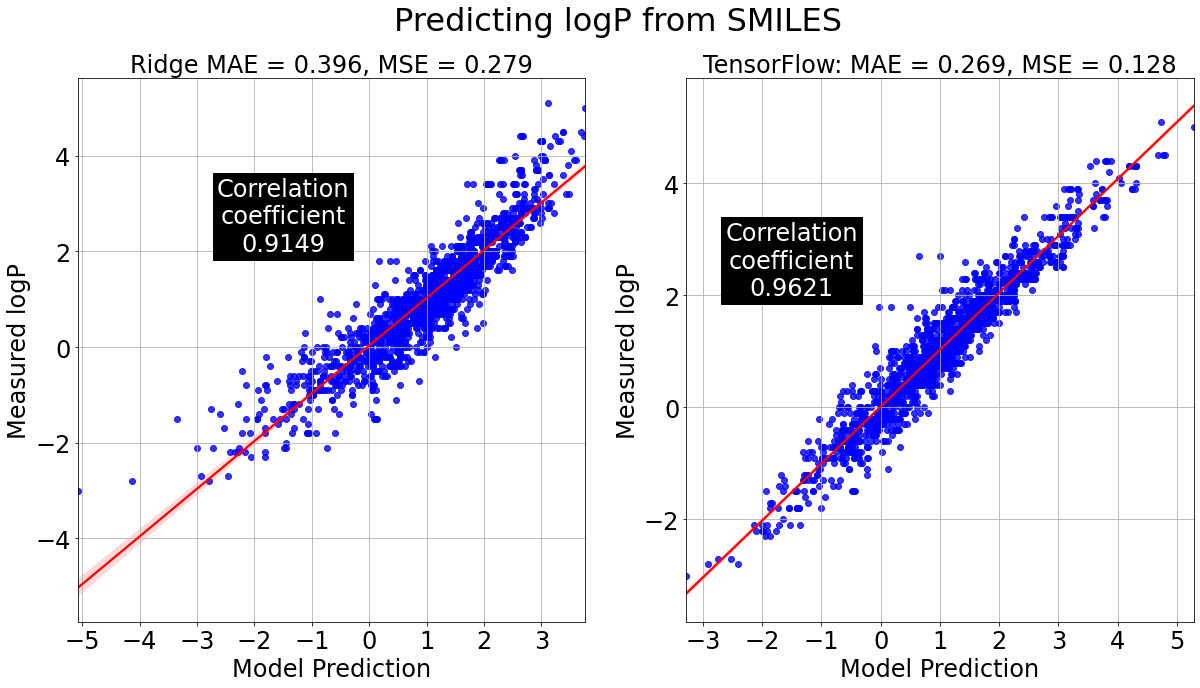

In [34]:
plot_both_evaluation(tf_model, ridge_model, X_test, y_test)

## OpenVINO™-TensorFlow Bridge

The [OpenVINO™-TensorFlow](https://github.com/openvinotoolkit/openvino_tensorflow) bridge optimizes deep learning inference on Intel® hardware. It is designed for developers who want to get started with OpenVINO™ with minimal modifications to their inference code. OpenVINO™ integration with TensorFlow accelerates inference across many AI models on a variety of Intel® silicon such as:

+ Intel® CPUs
+ Intel® integrated GPUs
+ Intel® Movidius™ Vision Processing Units - referred as VPU
+ Intel® Vision Accelerator Design with 8 Intel Movidius™ MyriadX VPUs - referred as VAD-M or HDDL

The current TensorFlow model is a trivial multi-layered network, but for more complex TensorFlow topologies there may be a significant speedup of inference. I'd encourage you to try other deep learning topologies to evaluate the speedups. Note: The truly optimal speedup on Intel® hardware can be obtained by converting the TensorFlow model to the [OpenVINO™](https://docs.openvinotoolkit.org/latest/index.html) format and using the native OpenVINO inference engine.

To install the OpenVINO™-TensorFlow bridge you can find specific directions [here](https://openvinotoolkit.github.io/openvino_tensorflow/)

In [35]:
#!pip install openvino-tensorflow==0.5.0
print('TensorFlow version: ', tf.__version__)
import openvino_tensorflow
print(openvino_tensorflow.__version__)

print(f"OpenVINO is enabled: {openvino_tensorflow.is_enabled()}")

TensorFlow version:  2.4.1
OpenVINO integration with TensorFlow version: b'0.5.0'
nGraph version used for this build: b'0.0.0+b33800a'
TensorFlow version used for this build: v2.4.0-49-g85c8b2a817f
CXX11_ABI flag used for this build: 0
OpenVINO integration with TensorFlow built with Grappler: False

OpenVINO is enabled: True


## Chosing the AI Hardware
The next command prints all available hardware for AI inference using OpenVINO™. We can easily switch between hardware using the `set_backend` command. That's it. The bridge does the rest.

In [36]:
openvino_tensorflow.list_backends()

['CPU']

In [37]:
openvino_tensorflow.set_backend('CPU')

In [38]:
loss, mse, mae = tf_model.evaluate(X_test, y_test)
prediction_ov = tf_model.predict(X_test)

46/46 [==============================] - 0s 615us/step - loss: 0.1281 - mse: 0.1281 - mae: 0.2693


In [39]:
print(f"The maximum difference between OpenVINO and TensorFlow predictions is {np.max(prediction_ov - prediction):.5f}")

The maximum difference between OpenVINO and TensorFlow predictions is 0.00000
